In [1]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.model_selection import KFold
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch

# MNIST Transform with Grayscale to RGB Conversion
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize(224),  # Resizing to 224 for compatibility with models like ResNet
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))  # Mean and std for each channel
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)




In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import torchvision.models as models
import torch
import torch.nn as nn

# Instantiate the VGG19 model
vgg19 = models.vgg19(pretrained=True)

# Modify the classifier for 10 output classes
num_features = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(num_features, 10)

# Move the model to the device
vgg19 = vgg19.to(device)

# If you have a fine-tuned model saved, you can load it
vgg19.load_state_dict(torch.load("fine_tuned_vgg19_mnist_new.pth"))

# Set the model to evaluation mode
vgg19.eval()


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
import torch
import torch.nn as nn
import math

import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class AdversarialCNN(nn.Module):
    def __init__(self):
        super(AdversarialCNN, self).__init__()
        # Initial convolution layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # Upsamples to 112x112
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # Upsamples to 224x224
        # self.conv4 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)  # Output 3 channels (RGB)
        self.conv4 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)  # Output 1 channel (Grayscale)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # Reduces size to 112x112
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # Reduces size to 56x56
        x = self.upsample1(x)  # Upsamples to 112x112
        x = F.relu(self.conv3(x))
        x = self.upsample2(x)  # Upsamples to 224x224
        x = torch.sigmoid(self.conv4(x))  # Using sigmoid to ensure output is between 0 and 1
        return x




In [5]:
import os
import torch.optim as optim

model_g = AdversarialCNN().to(device)
optimizer_g = torch.optim.Adam(model_g.parameters(), lr=0.001)
# Load checkpoint for model_g if available
checkpoint_path = 'checkpoint_final_CNN_1.pth'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model_g.load_state_dict(checkpoint['model_g_state_dict'])
    if 'optimizer_g_state_dict' in checkpoint:
        optimizer_g.load_state_dict(checkpoint['optimizer_g_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
else:
    start_epoch = 0

In [6]:
def train_g(model_g, model_f, train_loader, device=device, lambda_reg=2, lambda_l2=0.1, num_epochs=10):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model_g.train()
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            adversarial_images = model_g(images)
            adversarial_images = torch.clamp(adversarial_images, 0, 1)

            adversarial_images_3ch = adversarial_images.repeat(1, 3, 1, 1)
            outputs_f = model_f(adversarial_images_3ch)
            _, predictions = outputs_f.max(1)

            mse_loss = nn.MSELoss()(adversarial_images, images)
            loss_adv = criterion(outputs_f, labels)
            l2_norm_loss = torch.norm(adversarial_images - images)

            combined_loss = mse_loss + lambda_reg * loss_adv + lambda_l2 * l2_norm_loss

            optimizer_g.zero_grad()
            combined_loss.backward()
            optimizer_g.step()

            total_loss += combined_loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    print('Training complete.')


In [8]:
train_g(model_g, vgg19, train_loader)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([512, 3, 224, 224])) that is different to the input size (torch.Size([512, 1, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([96, 3, 224, 224])) that is different to the input size (torch.Size([96, 1, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 571.4384
Epoch [2/10], Loss: 545.1596
Epoch [3/10], Loss: 545.1161
Epoch [4/10], Loss: 545.0381
Epoch [5/10], Loss: 544.9541
Epoch [6/10], Loss: 545.0164
Epoch [7/10], Loss: 544.8952
Epoch [8/10], Loss: 544.8610
Epoch [9/10], Loss: 544.9880
Epoch [10/10], Loss: 544.7835
Training complete.


In [9]:
import torch

def evaluate_attack_effect(model_g, model_f, test_loader, device):
    model_g.eval()
    model_f.eval()

    original_correct = 0
    adversarial_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            total += labels.size(0)

            # Evaluate on original images
            if images.size(1) == 1:
                # Expand grayscale input images to RGB format
                images_3ch = images.repeat(1, 3, 1, 1)
            else:
                images_3ch = images

            outputs = model_f(images_3ch)
            _, predicted = torch.max(outputs.data, 1)
            original_correct += (predicted == labels).sum().item()

            # Generate adversarial images
            adversarial_images = model_g(images)
            adversarial_images = torch.clamp(adversarial_images, 0, 1)

            # Convert to 3-channel images for model_f
            adversarial_images_3ch = adversarial_images.repeat(1, 3, 1, 1)

            outputs_adv = model_f(adversarial_images_3ch)
            _, predicted_adv = torch.max(outputs_adv.data, 1)
            adversarial_correct += (predicted_adv == labels).sum().item()

    original_accuracy = 100 * original_correct / total
    adversarial_accuracy = 100 * adversarial_correct / total

    print(f'Accuracy on original images: {original_accuracy:.2f}%')
    print(f'Accuracy on adversarial images: {adversarial_accuracy:.2f}%')

    return original_accuracy, adversarial_accuracy


In [11]:
# Ensure that model_g, model_f, and test_loader are defined and loaded
original_accuracy, adversarial_accuracy = evaluate_attack_effect(model_g, vgg19, test_loader, device)


Accuracy on original images: 99.34%
Accuracy on adversarial images: 92.41%


In [14]:
import torchvision.models as models
import torch
import torch.nn as nn

# Instantiate the VGG19 model
vgg19 = models.vgg19(pretrained=True)

# Modify the classifier for 10 output classes
num_features = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(num_features, 10)

# Move the model to the device
vgg19 = vgg19.to(device)

# If you have a fine-tuned model saved, you can load it
vgg19.load_state_dict(torch.load("fine_tuned_vgg19_mnist.pth"))

# Set the model to evaluation mode
vgg19.eval()


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
original_accuracy, adversarial_accuracy = evaluate_attack_effect(model_g, vgg19, test_loader, device)


Accuracy on original images: 95.30%
Accuracy on adversarial images: 55.10%


In [12]:
import torchvision.models as models
import torch
import torch.nn as nn

# Instantiate the MobileNetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# Modify the final classifier layer for 10 output classes
num_features = mobilenet_v2.classifier[1].in_features
mobilenet_v2.classifier[1] = nn.Linear(num_features, 10)

# Move the model to the device
mobilenet_v2 = mobilenet_v2.to(device)

# If you have a fine-tuned model saved, you can load it
mobilenet_v2.load_state_dict(torch.load("fine_tuned_mobilenet_v2_mnist.pth"))

# Set the model to evaluation mode
mobilenet_v2.eval()


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
original_accuracy, adversarial_accuracy = evaluate_attack_effect(model_g, mobilenet_v2, test_loader, device)


Accuracy on original images: 96.52%
Accuracy on adversarial images: 16.34%


In [14]:
import matplotlib.pyplot as plt

def visualize_adversarial_examples(model_g, model_f, test_loader, device):
    model_g.eval()
    model_f.eval()

    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        adversarial_images = model_g(images)
        adversarial_images = torch.clamp(adversarial_images, 0, 1)

        # Convert to 3-channel images for model_f
        adversarial_images_3ch = adversarial_images.repeat(1, 3, 1, 1)

        original_preds = model_f(images).max(1)[1]
        adversarial_preds = model_f(adversarial_images_3ch).max(1)[1]

        # Calculate the noise
        noise = adversarial_images - images[:, 0, :, :].unsqueeze(1)

    plt.figure(figsize=(15, 10))
    for idx in range(5):  # Displaying only 5 examples
        # Original Image
        ax = plt.subplot(5, 3, idx * 3 + 1)
        plt.imshow(images[idx].cpu().detach().permute(1, 2, 0))
        plt.title(f"Orig: {labels[idx]}, Pred: {original_preds[idx]}")
        plt.axis('off')

        # Noise
        ax = plt.subplot(5, 3, idx * 3 + 2)
        noise_img = noise[idx].cpu().detach().squeeze()
        plt.imshow(noise_img, cmap='gray', vmin=0, vmax=1)
        plt.title("Noise")
        plt.axis('off')

        # Adversarial Image
        ax = plt.subplot(5, 3, idx * 3 + 3)
        adv_img = adversarial_images_3ch[idx].cpu().detach().permute(1, 2, 0)
        plt.imshow(adv_img)
        plt.title(f"Adv, Pred: {adversarial_preds[idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


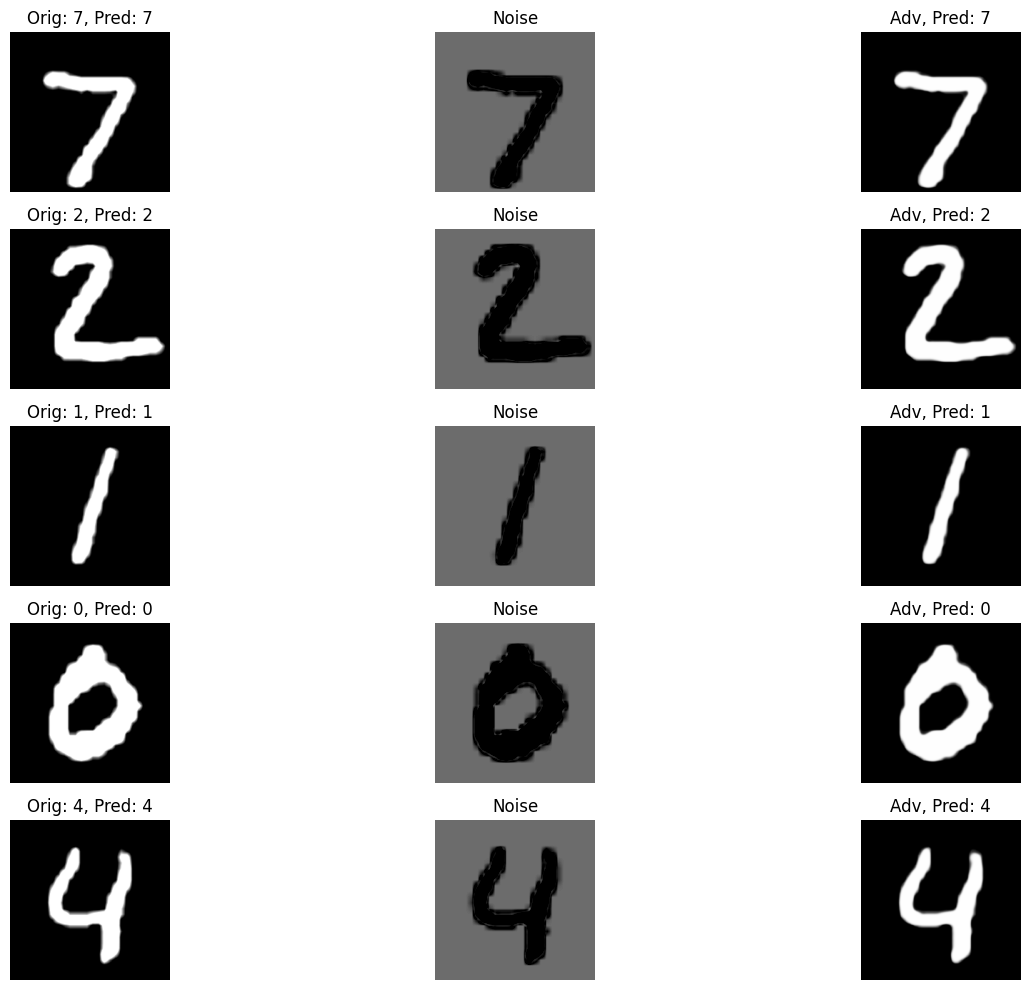

In [15]:
# Ensure that model_g, model_f, and test_loader are defined and loaded
visualize_adversarial_examples(model_g, vgg19, test_loader, device)

In [16]:
import matplotlib.pyplot as plt

def visualize_adversarial_examples(model_g, model_f, test_loader, device):
    model_g.eval()
    model_f.eval()

    # Fetch a batch of images
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        adversarial_images = model_g(images)
        adversarial_images = torch.clamp(adversarial_images, 0, 1)

        # Convert to 3-channel images for model_f
        adversarial_images_3ch = adversarial_images.repeat(1, 3, 1, 1)

        original_preds = model_f(images).max(1)[1]
        adversarial_preds = model_f(adversarial_images_3ch).max(1)[1]

        # Calculate the noise
        noise = adversarial_images - images[:, 0, :, :].unsqueeze(1)

    # Define the number of examples to display
    num_examples = min(50, images.shape[0])  # Adjust to the number of images in the batch if it's less than 50

    plt.figure(figsize=(15, 2 * num_examples))  # Adjusting figure size for visibility
    for idx in range(num_examples):
        # Original Image
        ax = plt.subplot(num_examples, 3, idx * 3 + 1)
        plt.imshow(images[idx].cpu().detach().permute(1, 2, 0))
        plt.title(f"Orig: {labels[idx]}, Pred: {original_preds[idx]}")
        plt.axis('off')

        # Noise
        ax = plt.subplot(num_examples, 3, idx * 3 + 2)
        noise_img = noise[idx].cpu().detach().squeeze()
        plt.imshow(noise_img, cmap='gray', vmin=0, vmax=1)
        plt.title("Noise")
        plt.axis('off')

        # Adversarial Image
        ax = plt.subplot(num_examples, 3, idx * 3 + 3)
        adv_img = adversarial_images_3ch[idx].cpu().detach().permute(1, 2, 0)
        plt.imshow(adv_img)
        plt.title(f"Adv, Pred: {adversarial_preds[idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

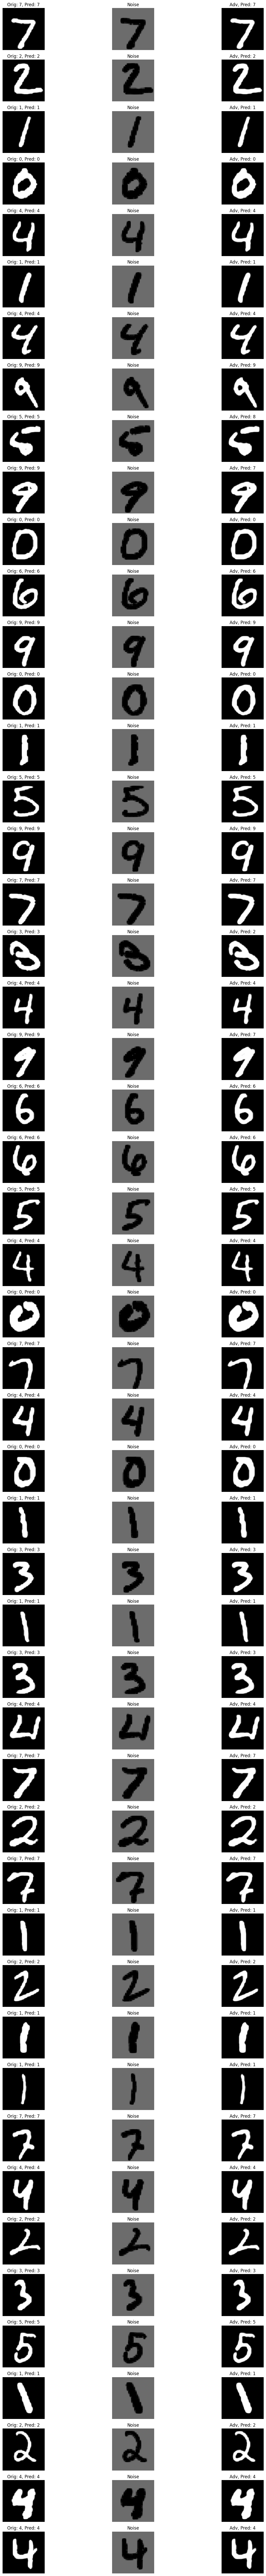

In [17]:
# Ensure that model_g, model_f, and test_loader are defined and loaded
visualize_adversarial_examples(model_g, vgg19, test_loader, device)

In [18]:
import torchvision.models as models
import torch
import torch.nn as nn
import math

# Instantiate the default ResNet101 model
resnet50 = models.resnet50(pretrained=True)

# Modify the final fully connected layer to have 10 output classes
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 10)

# Move the model to the device
resnet50 = resnet50.to(device)

# Load the saved state
resnet50.load_state_dict(torch.load("fine_tuned_res50_mnist_new.pth"))

# Set the model to evaluation mode
resnet50.eval()


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
original_accuracy, adversarial_accuracy = evaluate_attack_effect(model_g, resnet50, test_loader, device)


Accuracy on original images: 95.53%
Accuracy on adversarial images: 13.93%


In [20]:
import torchvision.models as models
import torch
import torch.nn as nn

# Instantiate the MobileNetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# Modify the final classifier layer for 10 output classes
num_features = mobilenet_v2.classifier[1].in_features
mobilenet_v2.classifier[1] = nn.Linear(num_features, 10)

# Move the model to the device
mobilenet_v2 = mobilenet_v2.to(device)

# If you have a fine-tuned model saved, you can load it
mobilenet_v2.load_state_dict(torch.load("fine_tuned_mobilenet_mnist_new.pth"))

# Set the model to evaluation mode
mobilenet_v2.eval()


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [21]:
original_accuracy, adversarial_accuracy = evaluate_attack_effect(model_g, mobilenet_v2, test_loader, device)


Accuracy on original images: 96.67%
Accuracy on adversarial images: 17.72%


In [22]:
import torchvision.models as models
import torch
import torch.nn as nn

# Instantiate the VGG19 model
vgg19 = models.vgg19(pretrained=True)

# Modify the classifier for 10 output classes
num_features = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(num_features, 10)

# Move the model to the device
vgg19 = vgg19.to(device)

# If you have a fine-tuned model saved, you can load it
vgg19.load_state_dict(torch.load("fine_tuned_vgg19_mnist_new.pth"))

# Set the model to evaluation mode
vgg19.eval()


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [23]:
original_accuracy, adversarial_accuracy = evaluate_attack_effect(model_g, vgg19, test_loader, device)


Accuracy on original images: 99.34%
Accuracy on adversarial images: 92.41%


In [24]:
import torchvision.models as models
import torch
import torch.nn as nn

# Instantiate the VGG19 model
vgg19 = models.vgg19(pretrained=True)

# Modify the classifier for 10 output classes
num_features = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(num_features, 10)

# Move the model to the device
vgg19 = vgg19.to(device)

# If you have a fine-tuned model saved, you can load it
vgg19.load_state_dict(torch.load("fine_tuned_vgg19_mnist.pth"))

# Set the model to evaluation mode
vgg19.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [25]:
original_accuracy, adversarial_accuracy = evaluate_attack_effect(model_g, vgg19, test_loader, device)


Accuracy on original images: 95.30%
Accuracy on adversarial images: 61.18%
